In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
def flows(t, y, kc):
    # Esta funcion representa al controlador proporcional cuya accion es de
    # rango divido considerando que la valvula del flujo caliente falla cerrada
    # (APA) y el de agua fria falla abierta (APC).
    
    trlag2 = y[4] 
    
    # Cambia el SP hasta que se alcance la temperatura deseada de reaccion
    trSp = TrSP0 + t * (TrSS - TrSP0)/Tramp 
    if trSp > TrSS:
        trSp = TrSS 
    
    # Cuando el tiempo de reaccion sea mayor a 55 min cambia la ganancia del
    # controlador a Kc = 0.05
    if t > Tramp + 10*60:
        kc = 0.05 
    
    # Calculo de la salida del controlador
    error = (trSp - trlag2)/Tspan 
    OP = 0.5 + kc * error 
    if OP > 1:
        OP = 1
    elif OP < 0:
        OP = 0

    fcold = 0 
    fhot = 0
    
    # Calculo de los flujos de agua fria y caliente
    if OP < 0.5:
        fcold = Fcoldmax*(0.5-OP)*2
    elif OP > 0.5:
        fhot = Fhotmax*(OP-0.5)*2 

    return [fcold, fhot, trSp]

def systemODE(t, y):
    # Esta funcion resuelve el sistema de ecuaciones diferenciales que modelan
    # el problema

    Ca = y[0]       # Concentracion del reactante
    Tr = y[1]       # Temperatura del reaccion
    Tj = y[2]       # Temperatura de refrigerante
    Trlag1 = y[3]   # Temperatura de reaccion perturbada
    Trlag2 = y[4]   # Temperatura de reaccion perturbada

    Q = U * Ahx * (Tj-Tr)     # Calor por intercambiador
    k = k0 * np.exp(-E/(R*Tr))   # Constante cinetica


    # Esto llama la funcion del controlador que calcula los flujos de agua fria
    # o caliente para el intercambiador de calor
    [Fcold, Fhot, TrSp] = flows(t, y, kc) 

    # Este es el conjunto de EDOs del problema
    dCa_dt = - k * Ca 
    dTr_dt = 1.0/(rho*Cp*Vr)*(Q + DHr * dCa_dt *Vr) 
    dTj_dt = ((Fcold*Tcold + Fhot*Thot)/Vj -
              (Fhot+Fcold)/Vj * Tj -
              Q/(Vj * rhoj * Cpj)) 

    # Esta es la salida del proceso que entrara al controlador de nuevo
    out_cont1 = (Tr - Trlag1)/taum 
    out_cont2 = (Trlag1 - Trlag2)/taum 

    return [dCa_dt, dTr_dt, dTj_dt, out_cont1, out_cont2]

def event(t, y):
    Climite = CAmax 
    r = y[1] - TmaxR 
    if y[0] >= CAmax:
        r = y[0] - CAmax
    return r

In [4]:
R = 8314      # Constante Universal de los gases    

# Datos de la reaccion
Cao = 8.01      # Concentracion inicial de A (kmol/m^3)
k0 = 20.75e6    # Factor preexponencial (s^-1)
E = 69.71e6     # Energia de activacion de la reaccion (J/kmol)
Cp = 3137       # Capacidad calorifica del fluido reaccionante
rho = 801       # Densidad del fluido reaccionante (kg/m^3)
DHr=-69.71e6    # Calor de reaccion (J/kmol)
TmaxR = 400     # Temperatura de reaccion maxima permitida (K)
T0 = 294          # temperatura inicial del batch (K)
Dr = 2            # Diametro del reactor (m)

# Datos del sistema de calentamiento/enfriamiento
Cpj = 4163              # Capacidad calorifica especifica del agua (J/kg K)
rhoj = 1000             # Densidad del agua (kg/m^3)
U = 851                 # Coeficiente global de transferencia de calor (W/m^2-K)
Thot = 373              # Temperatura de agua caliente (K)
Tcold = 294             # Temperatura de agua fria (K)

# configuracion del control
kc = 0.1      # Ganancia del controlador
tramp = 45      # Tiempo de la rampa (min)
Tspan = 50    # Span del transmisor de temperatura
XAmax = .95    # Maxima conversion permitida
Fhotmax = 1     # Flujo maximo de agua caliente (kg/s)
Fcoldmax = 1    # Flujo maximo de agua fria (kg/s)
TrSP0 = 300    # Temperatura inicial del setpoint
TrSS = 340    # Temperatura en estado estacionario
taum = 60     # Tau en min

# Calculos preliminares
Vr = np.pi * (Dr**2)*Dr/2     # Volumen del reactor (m^3)
Aj = 2 * np.pi *Dr**2          # Area de transferencia de la chaqueta (^2)
Ahx = Aj * 4              # Area del intercambiador externo (m^2)
Vj = 0.00258 * Ahx/0.4026  # Volumen del intercamdiador externo (m^3)
CAmax = Cao * (1 - XAmax)     # Maxima concentracion permitida

# Condiciones iniciales
ics = [Cao, T0, T0, T0, T0] 
Tramp = tramp * 60   # convierte el tiempo de rampa en segundos

# Esto resuelve el sistema de EDO considerando las restricciones de
# conversion y temperatura de reaccion maxima permitidas
event.terminal = True
event.direction = 0
solution = solve_ivp(systemODE, [0, 18000], ics, events=event)

In [5]:
vFcold = [] 
vFhot = [] 
vTrSp = []
solution_y_stack = np.vstack(solution.y.T)
for i in np.arange(len(solution.t)):
    [Fcold, Fhot, TrSp] = flows(solution.t[i], solution_y_stack[i], kc)
    vFcold.append(Fcold)
    vFhot.append(Fhot)
    vTrSp.append(TrSp)

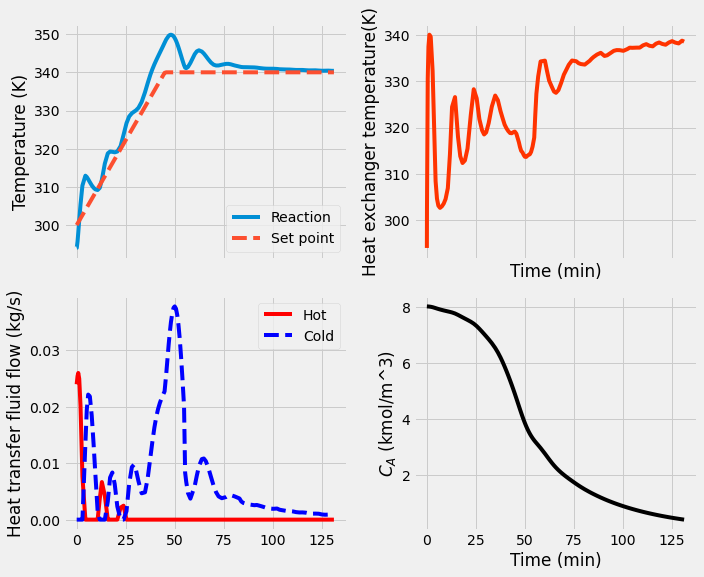

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

ax1.plot(solution.t/60, solution.y[1], label='Reaction')
ax1.plot(solution.t/60, vTrSp, label='Set point', ls='--')
ax1.set_ylabel('Temperature (K)')
ax1.legend(loc='best')

ax2.plot(solution.t/60, solution.y[2], color=[1, 0.200000002980232, 0]) 
ax2.set_ylabel('Heat exchanger temperature(K)') 
ax2.set_xlabel('Time (min)')

ax3.plot(solution.t/60, vFhot, color= [1, 0, 0], label='Hot') 
ax3.plot(solution.t/60, vFcold, color=[0, 0, 1], ls='--', label='Cold') 
ax3.set_ylabel('Heat transfer fluid flow (kg/s)')
ax3.legend(loc='best')

ax4.plot(solution.t/60 , solution.y[0], color=[0, 0, 0]) 
ax4.set_ylabel('$C_A$ (kmol/m^3)') 
ax4.set_xlabel('Time (min)') 

plt.tight_layout()
fig.savefig('../figures/003_03_01.png')
plt.show()

# Efecto del cambio de tama~o del reactor sobre la estabilidad de la reaccion

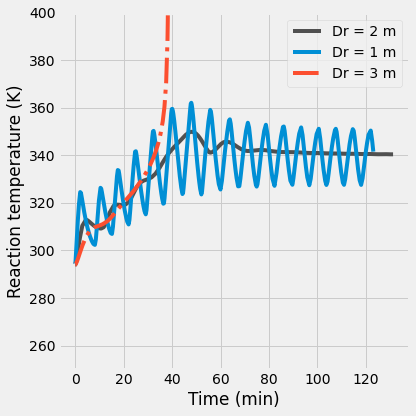

In [7]:
vDr = [1, 3] 

fig, ax =plt.subplots(figsize =(6, 6))
ax.set_ylim([250, 400]) 


ax.plot(solution.t/60, solution.y[1], 
        color=[0.313725501298904, 0.313725501298904, 0.313725501298904],
        label = 'Dr = 2 m') 

for i, diam in enumerate(vDr):
    Vr = np.pi*(diam**2) * diam/2    
    Aj = 2*np.pi*diam**2          
    Ahx = Aj*4             
    Vj = 0.00258*Ahx/.4026
    ics = [Cao, T0, T0, T0, T0] 
    Tramp = tramp*60  
    event.terminal = True
    event.direction = 0
    solution1 = solve_ivp(systemODE, [0, 18000], ics, events=event)
    linestyles = ['-','-.'] 
    ax.plot(solution1.t/60, solution1.y[1], 
            ls = linestyles[i],
            label = 'Dr = {} m'.format(diam))

ax.set_xlabel('Time (min)') 
ax.set_ylabel('Reaction temperature (K)') 
plt.legend(loc='best') 
plt.tight_layout()
plt.show()
    


